In [1]:
import jdc
import gc
from PIL import Image

import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
env = gym.make('CartPole-v1')
env.reset()

array([-0.03538387,  0.03210591, -0.00783928,  0.03925279])

## Fully-Connected Q-network (FCQ)


In [3]:
class FCQ:
    def __init__(self, input_shape, layers, activation_fc=tf.nn.relu) -> None:
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
        for i, l in enumerate(layers):
            self.model.add(tf.keras.layers.Dense(l, activation=None if i==len(layers)-1 else activation_fc))
            
        self.optimizer = tf.keras.optimizers.RMSprop(0.0005)
        self.loss = tf.keras.losses.MeanSquaredError()

    def fit(self, states, q_targets, actions):
        actions_tf = tf.convert_to_tensor(actions, dtype=tf.int32)
        with tf.GradientTape() as tape:
            q_values = self.model(states)
            q_actions = tf.gather(q_values, actions_tf, axis=1, batch_dims=1)
            loss_value = self.loss(q_targets, q_actions)

        grads = tape.gradient(loss_value, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

    def predict(self, x):
        return self.model.predict(x)

    def get_weights(self):
        return self.model.get_weights()

    def set_weights(self, weights):
        self.model.set_weights(weights)

    def save_model(self, name):
        self.model.save(name)

    def load_model(self, name):
        self.model = tf.keras.models.load_model(name)


In [4]:
FCQ((4,), (512,128,2)).model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2560      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 68,482
Trainable params: 68,482
Non-trainable params: 0
_________________________________________________________________


## Neural Fitted Q-iteration (NFQ)

In [5]:
class NFQ:
    def __init__(self, env, fcq, epsilon=0.1, gamma=1, batch_size=1024, epochs=40) -> None:
        self.fcq = fcq
        self.env = env
        self.batch_size = batch_size
        self.epochs = epochs
        self.epsilon = epsilon
        self.gamma = gamma

In [6]:
%%add_to NFQ

def train(self, n_episodes):
    # 1. get a batch of experiences
    # loop 1->k:
    #   2. calculate target
    #   3. fit Q values with RMSprops & MSE
    # goto 1
    experiences = []
    step_count = 0
    rewards = np.zeros(n_episodes)
    for i in range(n_episodes):
        state = self.env.reset()
        while True:
            step_count += 1
            action = self.epsilon_greedy_policy(state)
            state_p, reward, done, info = self.env.step(action)
            rewards[i] += reward
            is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
            is_failure = done and not is_truncated
            experiences.append((state, action, reward, state_p, float(is_failure)))

            if len(experiences) >= self.batch_size:
                experiences = np.array(experiences, dtype=object)
                batches = [np.vstack(s) for s in experiences.T]
                self.optimize(batches)
                experiences = []

            if done:
                break
            print("\rEpisode: {}, Steps: {}, Reward:{}".format(i, step_count, rewards[i]), end="") # Not shown

            state = state_p
    return rewards


In [7]:
%%add_to NFQ

def epsilon_greedy_policy(self, state):
    q_values = self.fcq.predict(np.expand_dims(state, axis=0))[0]
    if np.random.rand() < self.epsilon: 
        return np.random.randint(len(q_values))
    else:
        return np.argmax(q_values)

def greedy_policy(self, state):
    q_values = self.fcq.predict(np.expand_dims(state, axis=0))
    return np.argmax(q_values)


In [8]:
%%add_to NFQ

def optimize(self, batches):
    states, actions, rewards, states_p, is_terminals = batches
    for _ in range(self.epochs):
        q_states_p = self.fcq.model(states_p)
        max_q_states_p = tf.reduce_max(q_states_p, axis=1, keepdims=True)
        
        q_targets = rewards + self.gamma * max_q_states_p * (1 - is_terminals)
        masks = tf.one_hot(actions.ravel(), 2)
        self.fcq.fit(states, q_targets, masks)

In [9]:
fcq = FCQ((4,), (512,128,2))
env = gym.make("CartPole-v1")
# agent_nfq = NFQ(env, fcq, epsilon=0.1)
# rewards_nfq = agent_nfq.train(1600)

In [10]:
# plt.plot(rewards_nfq)
# plt.show()

## Deep Q-Network (DQN)

In [11]:
class ReplayBuffer:
    def __init__(self, max_size=50000) -> None:
        self.max_size = max_size
        self.next = 0
        self.size = 0

        self.states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.actions = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rewards = np.empty(shape=(max_size), dtype=np.ndarray)
        self.states_p = np.empty(shape=(max_size), dtype=np.ndarray)
        self.is_terminals = np.empty(shape=(max_size), dtype=np.ndarray)

    def __len__(self): return self.size
    
    def store(self, experience):
        state, action, reward, state_p, is_terminal = experience
        self.states[self.next] = state
        self.actions[self.next] = action
        self.rewards[self.next] = reward
        self.states_p[self.next] = state_p
        self.is_terminals[self.next] = is_terminal

        self.next += 1
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size=64):
        indices = np.random.choice(self.size, size=batch_size, replace=False)
        return np.vstack(self.states[indices]), \
            self.actions[indices], \
            self.rewards[indices], \
            np.vstack(self.states_p[indices]), \
            self.is_terminals[indices]


In [12]:
class DQN:
    def __init__(self, env, rb, online_nn, target_nn, gamma=1, min_buffer=320, network_update_rate=15) -> None:
        self.epsilon = 1
        self.min_epsilon = 0.1
        self.decay_rate = np.exp(np.log(self.min_epsilon) / 20_000) 
        self.gamma = gamma

        self.min_buffer = min_buffer
        self.network_update_rate = network_update_rate

        self.env = env
        self.replay_buffer = rb
        self.online_nn = online_nn
        self.target_nn = target_nn        


In [13]:
%%add_to DQN

def epsilon_greedy_exp_policy(self, state):
    q_values = self.online_nn.predict(np.expand_dims(state, axis=0))[0]
    if np.random.rand() < self.epsilon:
        action = np.random.randint(len(q_values))
    else:
        action = np.argmax(q_values)
    self.epsilon = max(self.min_epsilon, self.decay_rate * self.epsilon)
    return action

In [14]:
%%add_to DQN

def greedy_policy(self, state):
    q_values = self.online_nn.predict(np.expand_dims(state, axis=0))[0]
    action = np.argmax(q_values)
    return action

In [15]:
%%add_to DQN

def optimize(self, batches):
    states, actions, rewards, states_p, is_terminals = batches
    q_states_p = self.target_nn.model(states_p)
    max_q_states_p =tf.reduce_max(q_states_p, axis=1)
    
    q_targets = rewards + self.gamma * max_q_states_p * (1 - is_terminals)
    self.online_nn.fit(states, q_targets, actions)

In [16]:
%%add_to DQN

def train(self, n_episodes):
    step_count = 0
    rewards = np.zeros(n_episodes)
    for i in tqdm(range(n_episodes)):
        state = self.env.reset()
        while True:
            step_count += 1
            action = self.epsilon_greedy_exp_policy(state)
            state_p, reward, done, info = self.env.step(action)
            rewards[i] += reward
            is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
            is_failure = done and not is_truncated
            self.replay_buffer.store((state, action, reward, state_p, float(is_failure)))

            if len(self.replay_buffer) >= self.min_buffer:
                batches = self.replay_buffer.sample()
                self.optimize(batches)

            if step_count % self.network_update_rate == 0:
                self.target_nn.set_weights(self.online_nn.get_weights())

            if done:
                break
            # print("\rEpisode: {}, Steps: {}, eps: {:.3f}, Reward:{}".format(i, step_count, self.epsilon, rewards[i]), end="")

            state = state_p
    return rewards


In [17]:
%%add_to DQN

def play(self):
    state = self.env.reset()
    frames = []
    while True:
        frames.append(Image.fromarray(env.render(mode='rgb_array')))

        action = self.greedy_policy(state)
        state_p, reward, done, info = self.env.step(action)

        if done:
            break

        state = state_p
    env.close()
    return frames

In [18]:
env = gym.make("CartPole-v1")
rb = ReplayBuffer()
online_nn = FCQ((4,), (512,128,2))
target_nn = FCQ((4,), (512,128,2))

dqn = DQN(env, rb, online_nn, target_nn)
rewards_dqn = dqn.train(250)

100%|██████████| 250/250 [36:35<00:00,  8.78s/it]


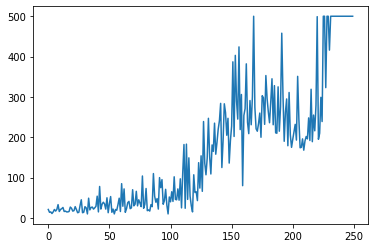

In [19]:
plt.plot(rewards_dqn)
plt.show()

In [19]:
frames = dqn.play()

In [20]:
with open('./openai_gym.gif', 'wb') as f:
    im = Image.new('RGB', frames[0].size)
    im.save(f, save_all=True, append_images=frames)

In [11]:
from IPython.display import HTML

HTML(data='''<img width="400" height="auto" src="cartpole-v1-dqn.gif" alt="g"/>''')

## Double DQN (DDQN)

In [18]:
class DDQN(DQN):
    def optimize(self, batches):
        states, actions, rewards, states_p, is_terminals = batches
        q_states_p = self.target_nn.model(states_p)
        q_states_p_online = self.online_nn.model(states_p)
        actions_p = tf.argmax(q_states_p_online, axis=1)

        max_q_states_p = tf.gather(q_states_p, actions_p, axis=1, batch_dims=1)

        q_targets = rewards + self.gamma * max_q_states_p * (1 - is_terminals)
        self.online_nn.fit(states, q_targets, actions)

In [19]:
env = gym.make("CartPole-v1")
rb = ReplayBuffer()
online_nn = FCQ((4,), (512,128,2))
target_nn = FCQ((4,), (512,128,2))

ddqn = DDQN(env, rb, online_nn, target_nn)
rewards_ddqn = ddqn.train(250)

100%|██████████| 250/250 [36:56<00:00,  8.87s/it]


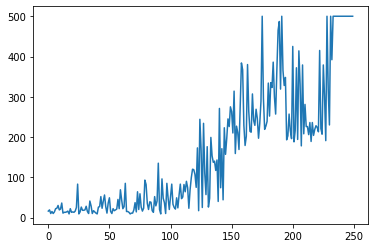

In [20]:
plt.plot(rewards_ddqn)
plt.show()

In [21]:
online_nn.save_model("ddqn_online_nn.h5")
target_nn.save_model("ddqn_target_nn.h5")